# Project Report: PLAIcraft

In [3]:
# Install if you are missing these packages!
# install.packages("caret")
# install.packages("kknn")

library(tidyverse)
library(repr)
library(tidymodels)
library(caret)
library(patchwork)

options(repr.plot.height = 10, repr.plot.width = 10)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

A [research group](https://plai.cs.ubc.ca/) at UBC collected data about how people play video games using a [MineCraft server](https://plaicraft.ai/) and recording players' actions. 

Data regarding all the players' information was collected as players signed in to play the game. 

## 1) `Players` Dataset Description:

In [4]:
players <- read_csv("https://raw.githubusercontent.com/audreyw28/DSCI100-2025W1-004-42/refs/heads/main/players.csv")
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [5]:
#CALCULATING SUMMARY STATISTICS: RANGE, MEAN, STANDARD DEVIATION

players_range <- players|>
    reframe(played_hours_range = range(played_hours), 
              age_range = range(Age, na.rm = TRUE))
players_range

players_stats <- players|>
    summarize(played_hours_mean = round(mean(played_hours), 2),
              played_hours_sd = round(sd(played_hours), 2),
              age_mean = round(mean(Age, na.rm = TRUE), 2), 
              age_sd = round(sd(Age, na.rm = TRUE), 2))
players_stats

# sum(is.na(players))

played_hours_range,age_range
<dbl>,<dbl>
0.0,9
223.1,58


played_hours_mean,played_hours_sd,age_mean,age_sd
<dbl>,<dbl>,<dbl>,<dbl>
5.85,28.36,21.14,7.39


In the `players` dataset, there are:
- 196 observations, each of one player
- 7 variables:

| Variable | Type | Description |
|:---|:---|:---|
| `experience` | character | experience level of player |
| `subscribe` | logical | whether the player has subscribed to the game or not |
| `hashedEmail` | character | hashed email of player |
| `played_hours` | double | number of hours played (hours)|
| `name` | character | name of player |
| `gender` | character | gender of player |
| `Age` | double | age of player (years) |

`played_hours` has: 
- range of 0 - 223.1
- mean of 5.85
- standard deviation of 28.36

`Age` has:
- range of 9 - 58
- mean of 21.14
- standard deviation of 7.39

Issues exist in this dataset in that: 
- 2 player ages were missing (NA) $ \rightarrow $ decreased accuracy when performing summary statistics for `Age`
- the experience levels were self-declared by players $ \rightarrow $ could be biased when players over/under estimate their ability

## 2) Investigated Question:

For the report, we want to know which player characteristics are most predictive of subscribing to a game-related newsletter.
-  If someone is subscribed, that means they are more engaged with the game.
-  `name`, `hashedEmail`, and `gender` are unlikely to be informative in predicting `subscribe`.
-  `Age` may be predictive if the game appeals to players of certain ages $ \rightarrow $ players are more likely to subscribe.
-  `played_hours` may be predictive since higher played hours means the player has a higher affinity for the game $ \rightarrow $ players are more likely to subscribe.
-  Although `experience` is self-declared and holds a certain extent of uncertainty, it is still likely that players with a certain experience level might be more engaged and therefore likely to subscribe to the game. 

Therefore, our specific question is:
- Can `experience`, along with `Age` and `played_hours` predict `subscribe` in the `players` dataset?

The `players` dataset will make this K-nearest-neighbors classification problem possible by providing a sufficient number of observations (194) of players and their respective `played_hours`, `Age`, `experience`and `subscribe`. 

## 3) Exploratory Data Analysis

The dataset is tidy; variables of interest (`played_hours`, `Age`, `experience` and `subscribe`) are in separate columns, and each observation is one player. 

To cater the data to answering our specific question, we will: 
- select for my interested variables
- drop NAs
- convert any non-numeric (character) variables to factor variables since they will be used as categorical variables
- assign levels to `experience` since it can be ordered
- recode the `subscribe` variable into "Yes" and "No" to increase the readability of our analysis

In [8]:
players <- players |>
    select(subscribe, Age, played_hours, experience)|>
    drop_na()|>
    mutate(experience = factor(experience,
                               levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran")), 
           subscribe = as_factor(subscribe),
           subscribe = fct_recode(subscribe, "Yes" = "TRUE", "No" = "FALSE"))
head(players)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `subscribe = fct_recode(subscribe, Yes = "TRUE", No = "FALSE")`.
Caused by warning:
! Unknown levels in `f`: TRUE, FALSE”


subscribe,Age,played_hours,experience
<fct>,<dbl>,<dbl>,<fct>
Yes,9,30.3,Pro
Yes,17,3.8,Veteran
No,17,0.0,Veteran
Yes,21,0.7,Amateur
Yes,21,0.1,Regular
Yes,17,0.0,Amateur


In [9]:
# CALCULATING NUMBER AND PERCENTAGE OF SUBSCRIBED AND NOT SUBSCRIBED OBSERVATIONS
num_obs <- nrow(players)
players |>
  group_by(subscribe) |>
  summarize(
    count = n(),
    percentage = n() / num_obs * 100)

subscribe,count,percentage
<fct>,<int>,<dbl>
No,52,26.80412
Yes,142,73.19588


The response/target variable (`subscribe`) is not extremely imbalanced, so we do not have to worry about data imbalance when performing K-nearest-neighbors classification. 

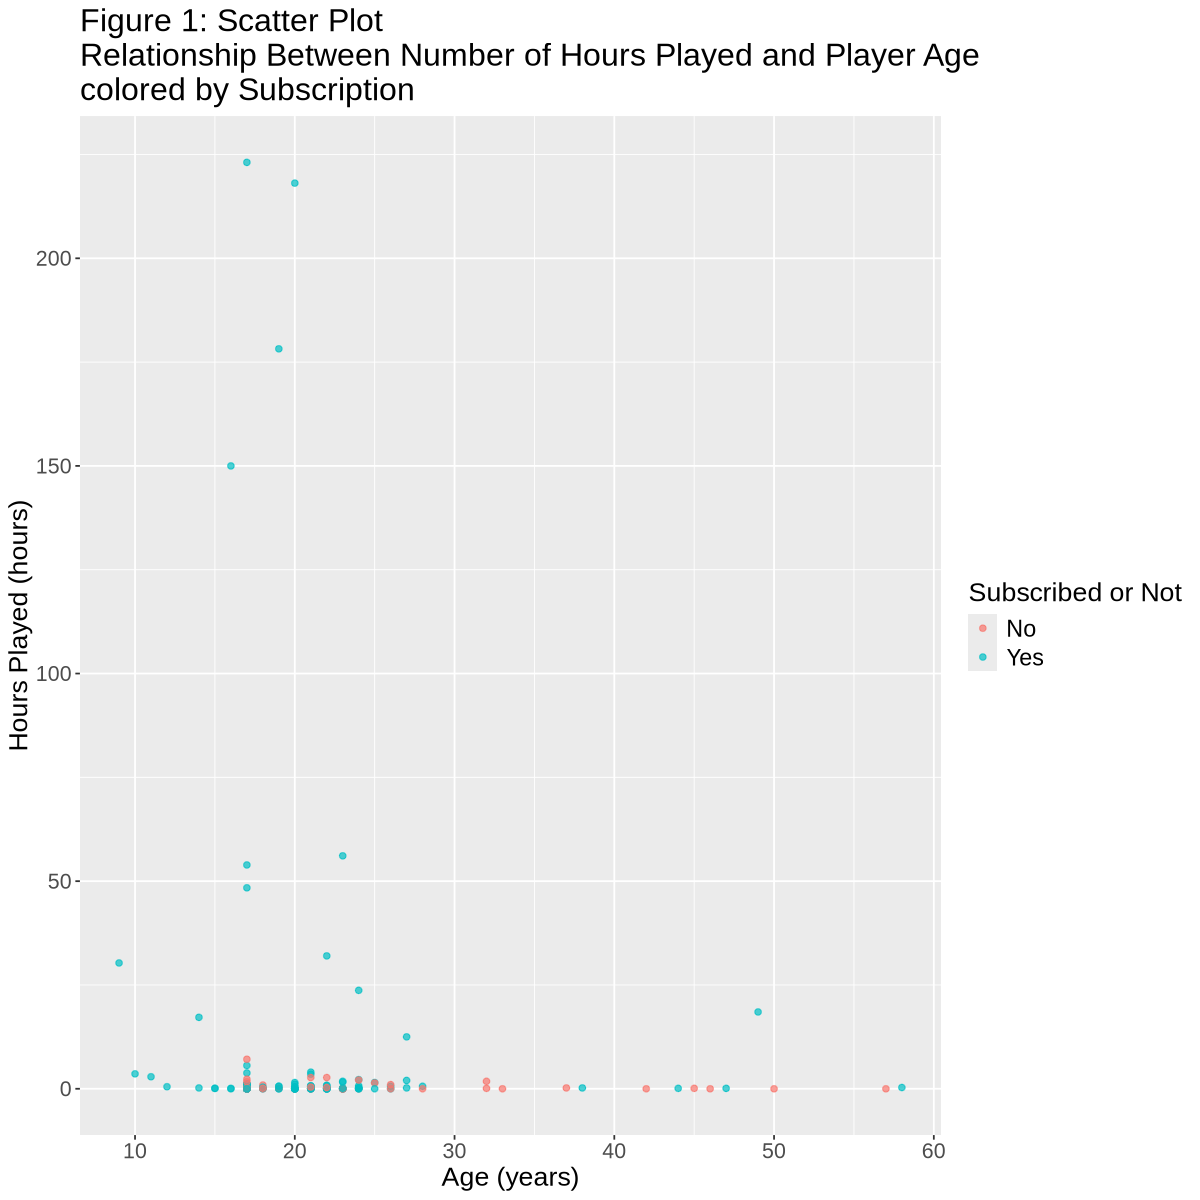

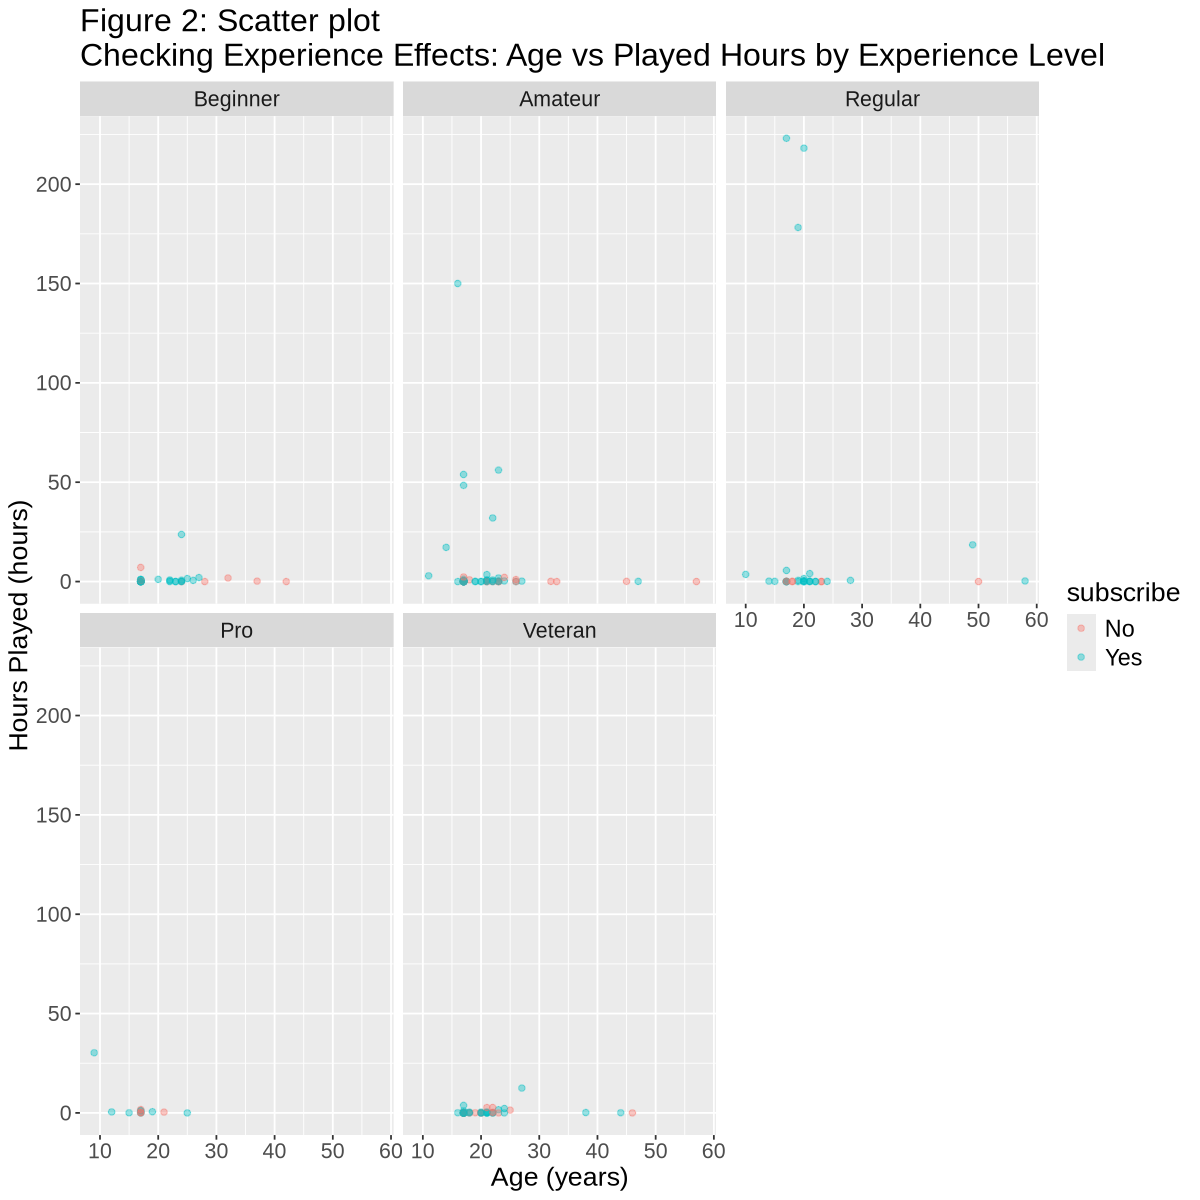

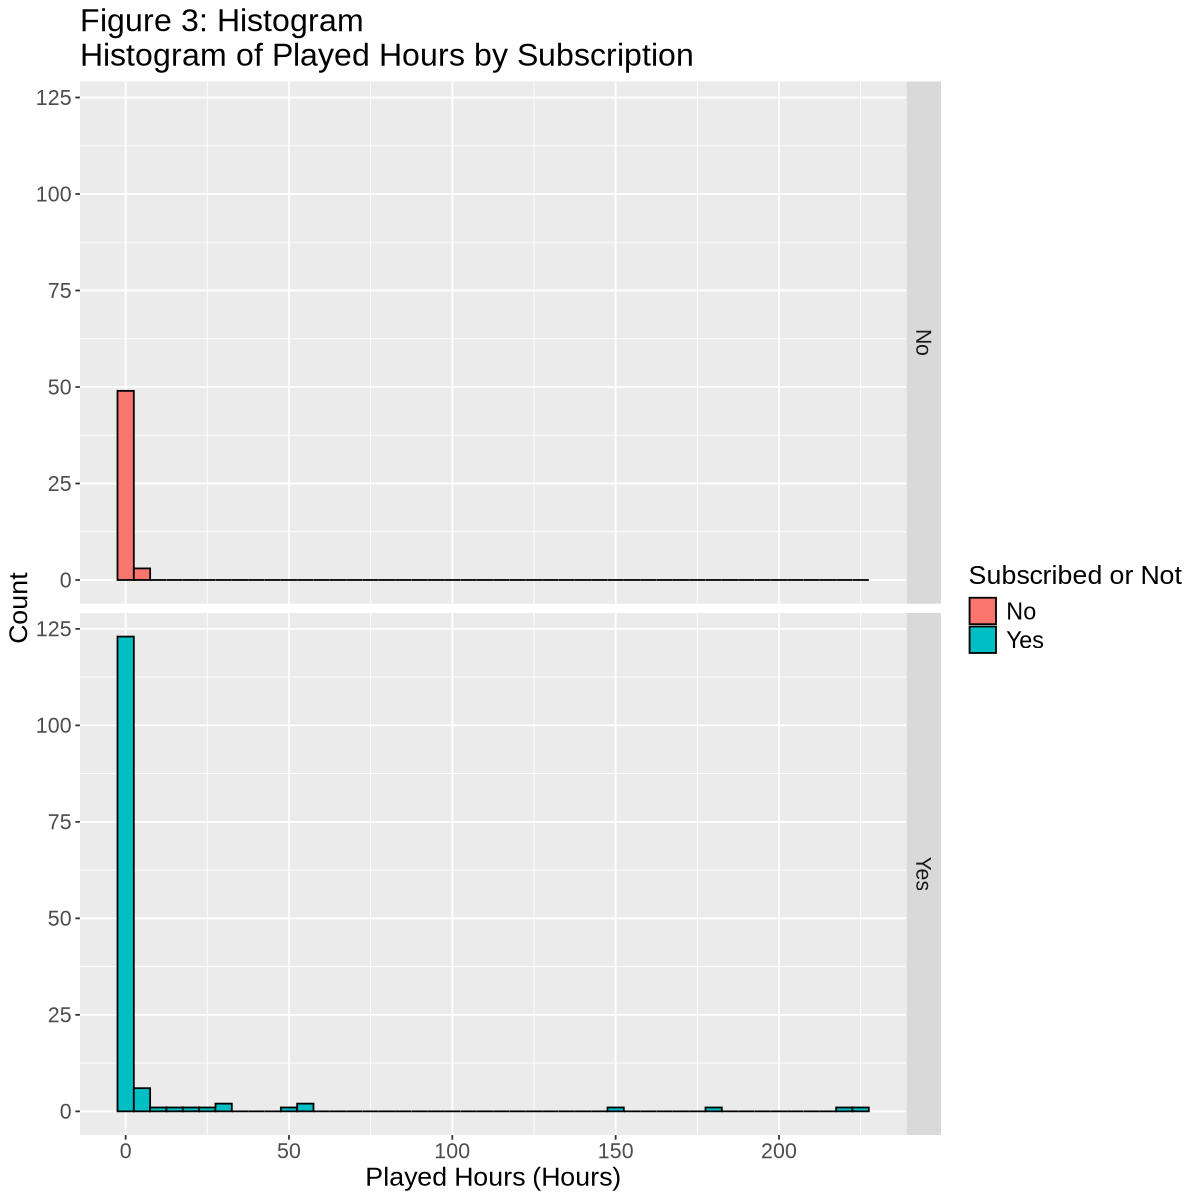

In [14]:
figure_1 <- ggplot(players, aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.7) +
    scale_color_discrete(name = "Subscribed or Not") +
    labs(x = "Age (years)", 
         y = "Hours Played (hours)", 
         title = "Figure 1: Scatter Plot\nRelationship Between Number of Hours Played and Player Age\ncolored by Subscription") +
    theme(text = element_text(size = 16), 
         legend.text = element_text(size = 14),
         legend.title = element_text(size = 16))
    # scale_y_log10(labels = label_comma())+
    # scale_x_log10(labels = label_comma())
figure_1

figure_2 <- ggplot(players, aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.4) +
    facet_wrap(~ experience) +
    labs(title = "Figure 2: Scatter plot\nChecking Experience Effects: Age vs Played Hours by Experience Level",
         x = "Age (years)",
         y = "Hours Played (hours)") +
        theme(text = element_text(size = 16), 
        legend.text = element_text(size = 14),
        legend.title = element_text(size = 16))
figure_2

figure_3 <- ggplot(players, aes(x = played_hours, fill = subscribe))+
    geom_histogram(position = "identity", binwidth = 5, color = "black") + 
    scale_fill_discrete(labels = c("No", "Yes"),
                         name = "Subscribed or Not") +
    labs(x = "Played Hours (Hours)", 
         y = "Count", 
         title = "Figure 3: Histogram\nHistogram of Played Hours by Subscription") +
    facet_grid(rows = vars(subscribe)) +
    theme(text = element_text(size = 16), 
         legend.text = element_text(size = 14),
         legend.title = element_text(size = 16))
figure_3

Through **figure 1**, we see that higher `played_hours` and lower `Age` is associated with players often being subscribed. This suggests that `played_hours` and `Age` may be useful predictors of subscription. 

From faceting the plot by experience level in **figure 2**, the overall relationship looks similar across groups. We do not observe any drastically different patterns across experience groups. 

However, relationships involving experience may still exist in higher dimensions and may not be visually obvious in the 2D plots. Therefore, are including `experience` in our model, along with `Age` and `played_hours` to test whether it improves prediction performance.

**Figure 3** further reinforces that players with high `played_hours` are likely to be subscribed. Therefore, `played_hours` can be used as a predictor variable.

In [9]:
# CHECKING NUMBER OF OBSERVATIONS IN EACH EXPERIENCE LEVEL
# players |>
# group_by(experience) |>
# summarize(count = n())

## 4) Methods and Results

Some steps in creating our models: 
1. Set seeds when splitting data and running each cross validation to ensure reproducibility. 
2. Split data into 70% training and 30% (most commonly used proportion in our current experience of predictive analysis)
3. `Age` and `played_hours` will be scaled to have a mean of 0 and standard deviation of 1.
4. `experience` will be converted from factor/nominal variables to [binary dummy variables](https://recipes.tidymodels.org/reference/step_dummy.html) to use as predictors in the `recipe` function. 
5. Perform 5-fold cross validation (most commonly used in this course and saves memory) on 1-30 neighbors (K range ~1/5 of the training data observations) to tune the model.
6. Select neighbors with the highest cross-validated accuracy for our final model.

In [86]:
set.seed(100)

# split data into training and testing set
players_split <- initial_split(players, prop = 0.70, strata = subscribe)  
players_train <- training(players_split)   
players_test <- testing(players_split)

### We will first make the 1st model: using `Age`, `played_hours` and `experience` to predict `subscribe`

We will first **tune the model** to find the K neighbors value with highest accuracy.

In [87]:
# create recipe to tune for best neighbors
players_recipe1.0 <- recipe(subscribe ~ Age + played_hours + experience, 
                            data = players_train) |>
    step_dummy(experience) |>                    # convert `experience` to dummies
    step_center(all_numeric_predictors()) |>     # center numeric columns
    step_scale(all_numeric_predictors())         # scale only numeric columns

In [88]:
set.seed(100)

#number of neighbors to cross validate on (UPPER LIMIT FOR NEIGHBORS = 1/5th of training set size)
k_vals <- tibble(neighbors = seq(from = 1, to = 30, by = 1))

# model specification for tuning
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# number of folds
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

# fit model and collect metrics dataframe
knn_results1.0 <- workflow() |>
       add_recipe(players_recipe1.0) |>
       add_model(knn_tune) |>
       tune_grid(resamples = players_vfold, grid = k_vals) |>
       collect_metrics() |>
       filter(.metric == "accuracy")

# find k with highest accuracy
best_k1 <- knn_results1.0 |>
        arrange(desc(mean)) |>
        head(1)
best_k1

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
9,accuracy,binary,0.7334758,5,0.01749355,Preprocessor1_Model09


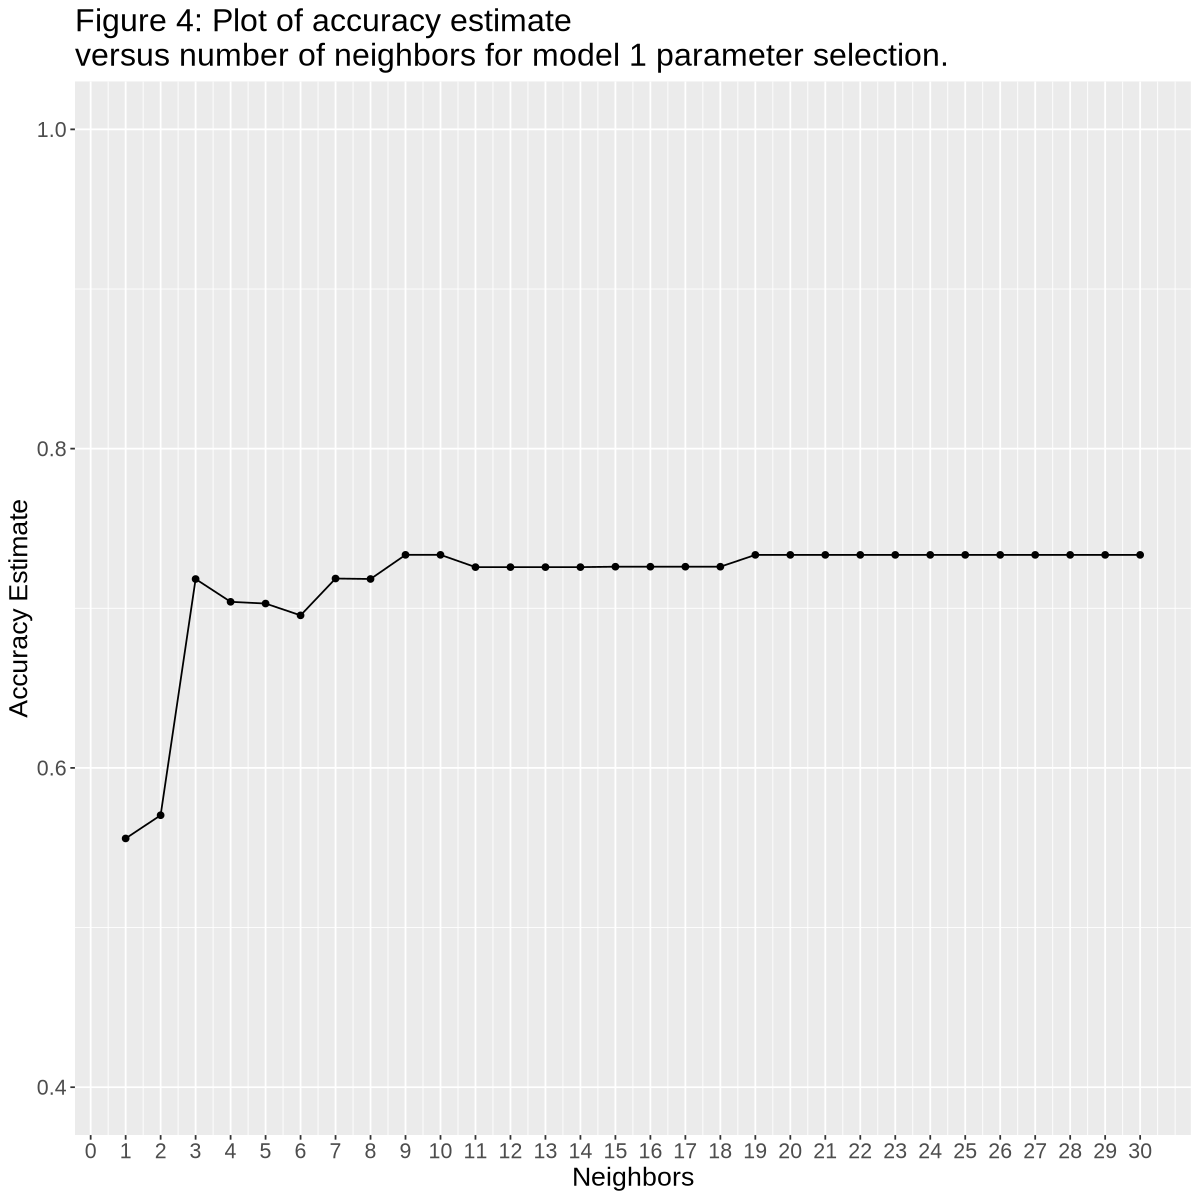

In [89]:
# plotting estimated accuracy versus number of neighbors for better interpretability of results
figure_4 <- ggplot(knn_results1.0, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", 
            y = "Accuracy Estimate", 
            title = "Figure 4: Plot of accuracy estimate\nversus number of neighbors for model 1 parameter selection.") +
       scale_x_continuous(breaks = seq(0, 30, by = 1)) +  
       scale_y_continuous(limits = c(0.4, 1.0)) + 
       theme(text = element_text(size = 16))
figure_4

**Highest accuracy occurs at k=17 at 74.1% accuracy.**

### 2nd model: using `Age` and `played_hours` to predict

We will use the same tuning specification, cross validation folds, and number of k values to test as model 1.

In [94]:
# create recipe to tune for best neighbors
players_recipe2.0 <- recipe(subscribe ~ Age + played_hours, data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

In [96]:
set.seed(1001)

# use the same knn_tune, players_vfold, and kvals as the 1st model
# fit model and collect metrics dataframe
knn_results2.0 <- workflow() |>
       add_recipe(players_recipe2.0) |>
       add_model(knn_tune) |>
       tune_grid(resamples = players_vfold, grid = k_vals) |>
       collect_metrics() |>
       filter(.metric == "accuracy")

# find k with highest accuracy
best_k2 <- knn_results2.0 |>
        arrange(desc(mean)) |>
        head(1)
best_k2

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
17,accuracy,binary,0.7403134,5,0.01378826,Preprocessor1_Model17


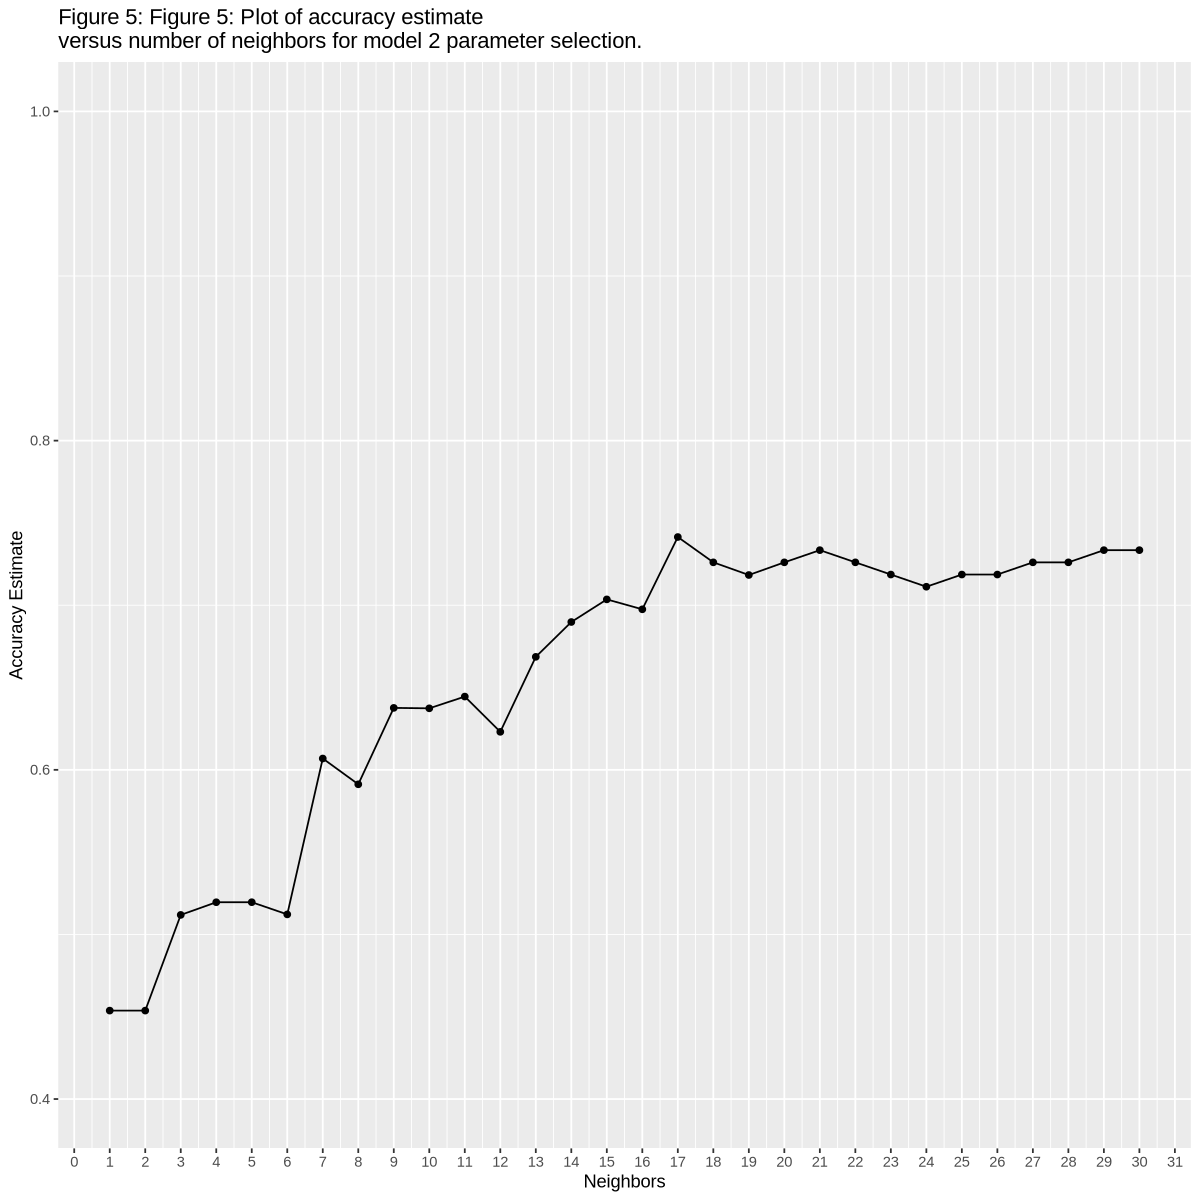

In [74]:
# plot of estimated accuracy versus number of neighbors
figure_5 <- ggplot(knn_results2.0, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", 
            y = "Accuracy Estimate", 
            title = "Figure 5: Figure 5: Plot of accuracy estimate\nversus number of neighbors for model 2 parameter selection.") +
       scale_x_continuous(breaks = seq(0, 40, by = 1)) +  
       scale_y_continuous(limits = c(0.4, 1.0)) 
figure_5

**Highest accuracy occurs at k=17 at 75.6% accuracy for model 2.**

### Therefore, since model 2 achieved the highest cross-validated accuracy, we select the k value that produced the highest cross-validated accuracy within model 2 to build a new model with the optimal k value to fit on the training set and evaluate its accuracy on the test set.  

In [83]:
# model specification for final value
knn_spec_final <- nearest_neighbor(weight_func = "rectangular", neighbors = 17) |>
    set_engine("kknn") |>
    set_mode("classification")

# fit model and collect metrics dataframe
# use recipe from above
knn_results_final <- workflow() |>
       add_recipe(players_recipe2.0) |>
       add_model(knn_spec_final) |>
       fit(players_train)

# find accuracy of the model by making it predict the testing set
players_predictions <- predict(knn_results_final, players_test) |>
  bind_cols(players_test)
players_predictions

players_accuracy <- players_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")
players_accuracy

.pred_class,subscribe,Age,played_hours,experience
<fct>,<fct>,<dbl>,<dbl>,<fct>
Yes,No,17,0.0,Veteran
Yes,Yes,21,0.1,Regular
Yes,No,21,0.0,Amateur
Yes,Yes,23,1.6,Veteran
Yes,Yes,22,0.2,Amateur
Yes,Yes,17,0.0,Veteran
Yes,Yes,17,0.0,Beginner
Yes,Yes,17,0.0,Beginner
Yes,Yes,28,0.6,Regular


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7288136


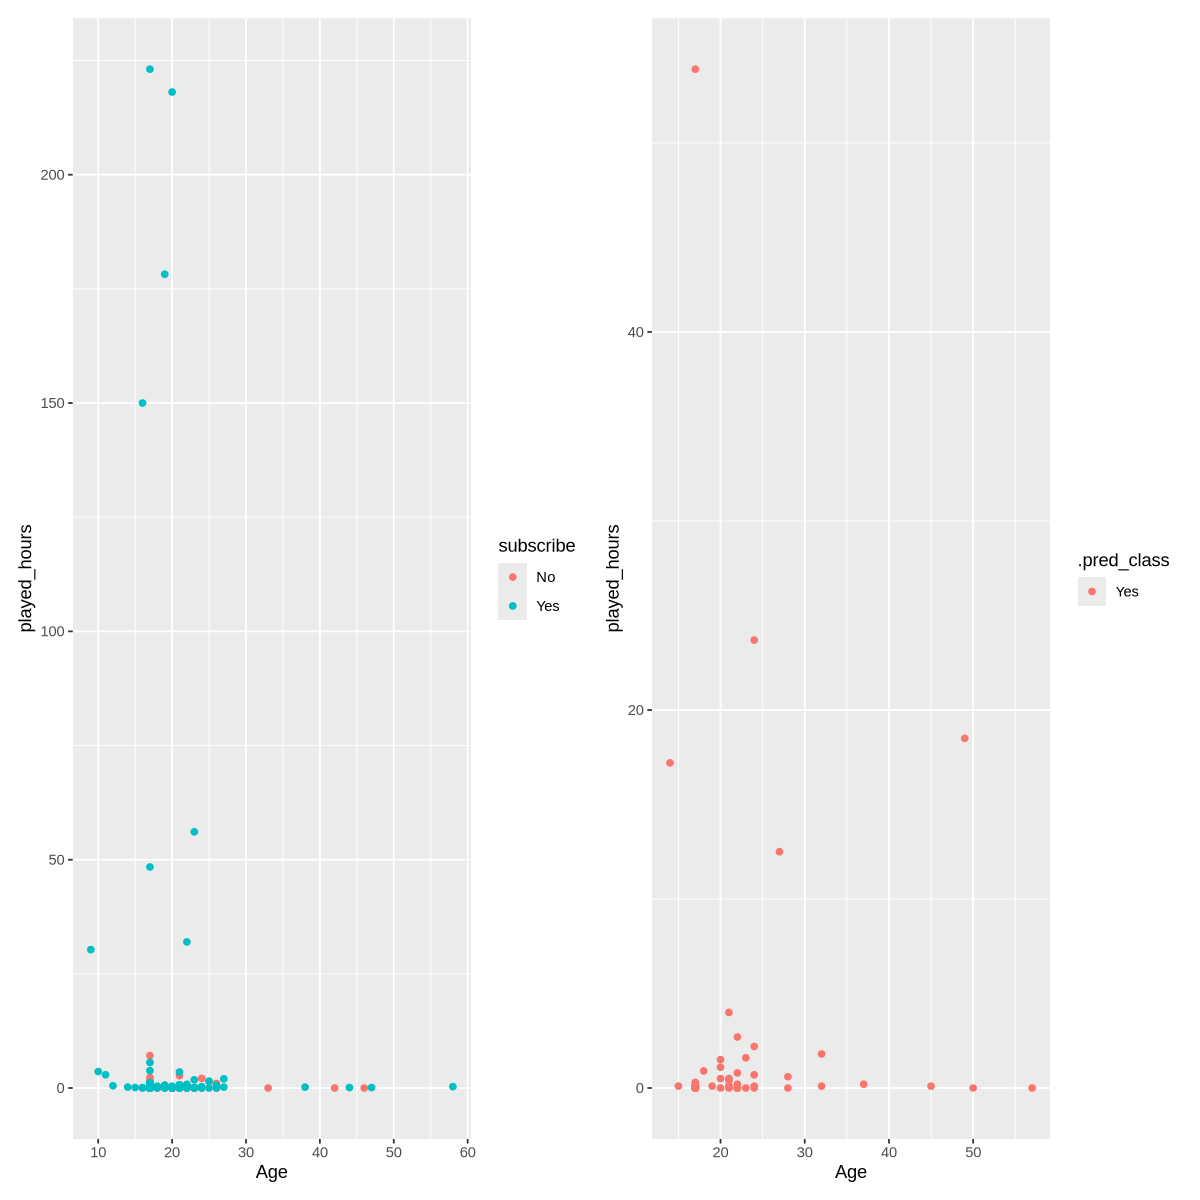

In [84]:
#
train_plot <- ggplot(players_train, aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point()

test_plot <- ggplot(players_predictions, aes(x = Age, y = played_hours, color = .pred_class)) +
    geom_point()

figure_6 <- train_plot + test_plot
figure_6

**For using `Age` and `played_hours` to predict `subscribe` on the testing set, the accuracy is around 72.3%.**

From figure 6, 

### 5) Discussion

- summarize what was found:
  - using 3 predictors yielded a lower accuracy than using 2 predictors
  - number of neighbors are pretty similar (11vs18) compared on the scale of total observations (196)
  - since using 2 predictors gave a higher accuracy, but uses more neighbors, that means creating and using the model will use a significantly larger amount of memory to run. therefore, it is crucial that we balance between the simplicity and accuracy. 
- discuss whether this is what you expected to find:
  - Overall accuracy: yes, since through EDA and common sense logic, the played hours and age should be able to help us predict in whether someone will subscribe or not (these are reasonable predictors, compared to gender which is definitely not informative)
  - Comparing models: yes, this is what we expected, since through the facet grid graph, we didn't see any distinct relationship between each experience level, so it was likely that experience isn't a useful predictor. However, it was still tested since there could be a relationship that we could not interpret visually with the 2D graph. 
  - also discuss why the model doesnt have a higher accuracy
- discuss what impact could such findings have:
  - Be able to help the research team in predicting whether people will subscribe in the future?if someone subscribes that means higher engagement, and more likely to return to the game. 
- discuss what future questions could this lead to: